# Training a NN for metric on CICY with homog

## Import the required packages/functions

In [1]:
#disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [171]:
import numpy as np
import gc
import sys
import os
import re
import logging
import pickle
import sys
#sys.path.append("/Users/kit/Documents/Phys_Working/MF metric")
#sys.path.append("/home/f/fraser-talientec/PhysicalYukawas")
sys.path.append("/home/f/fraser-talientec/cymetricap/AlphaPrime")

logging.basicConfig(stream=sys.stdout)

from cymetric.pointgen.pointgen import PointGenerator
from cymetric.pointgen.nphelper import prepare_dataset, prepare_basis_pickle

import tensorflow as tf
import tensorflow.keras as tfk

tf.get_logger().setLevel('ERROR')


from cymetric.models.tfmodels import PhiFSModel, MultFSModel, FreeModel, MatrixFSModel, AddFSModel, PhiFSModelToric, MatrixFSModelToric
from cymetric.models.tfhelper import prepare_tf_basis, train_model
from cymetric.models.callbacks import SigmaCallback, KaehlerCallback, TransitionCallback, RicciCallback, VolkCallback, AlphaCallback
from cymetric.models.metrics import SigmaLoss, KaehlerLoss, TransitionLoss, RicciLoss, VolkLoss, TotalLoss

from NewCustomMetrics import *
from laplacian_funcs import *
#from generate_and_train_all_nnsHOLO import *
from custom_networks import *
import sys
import importlib
from AlphaPrimeModel import *
#reimport ALphaPrimeModel
importlib.reload(sys.modules['AlphaPrimeModel'])
from AlphaPrimeModel import *
#reimport custom_networks
importlib.reload(sys.modules['custom_networks'])
from custom_networks import *




## Point Cloud Generation

In [160]:

def create_adam_optimizer_with_decay(initial_learning_rate, nEpochs, final_lr_factor=10):
    """
    Creates an Adam optimizer with exponential learning rate decay.

    Parameters:
    - initial_learning_rate: The starting learning rate
    - nEpochs: The number of epochs over which to decay the learning rate
    - final_lr_factor: The factor by which to reduce the learning rate (default: 10)

    Returns:
    - An Adam optimizer with the specified learning rate decay
    """
    decay_rate = (1/final_lr_factor) ** (1/nEpochs)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1,
        decay_rate=decay_rate,
        staircase=False
    )

    return tf.keras.optimizers.Adam(learning_rate=lr_schedule)

def generate_points_and_save_using_defaults(free_coefficient,number_points,force_generate=False,seed_set=0):
   coefficients=coefficientsTQ
   # coefficients=np.array([1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, \
   # 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, free_coefficient, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1])
   monomials=monomialsTQ
   kmoduli=kmoduliTQ
   ambient=ambientTQ
   pg = PointGenerator(monomials, coefficients, kmoduli, ambient)
   pg._set_seed(seed_set)
   #dirname = 'data/tetraquadric_pg_wit#h_'+str(free_coefficient)
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   print("dirname: " + dirname)
   #test if the directory exists, if not, create it
   if force_generate or (not os.path.exists(dirname)):
      print("Generating: forced? " + str(force_generate))
      kappa = pg.prepare_dataset(number_points, dirname)
      pg.prepare_basis(dirname, kappa=kappa)
   elif os.path.exists(dirname):
      try:
         print("loading prexisting dataset")
         data = np.load(os.path.join(dirname, 'dataset.npz'))
         if (len(data['X_train'])+len(data['X_val']))!=number_points:
            print("wrong length - generating anyway")
            kappa = pg.prepare_dataset(number_points, dirname)
            pg.prepare_basis(dirname, kappa=kappa)
      except:
         print("error loading - generating anyway")
         kappa = pg.prepare_dataset(number_points, dirname)
         pg.prepare_basis(dirname, kappa=kappa)


def getcallbacksandmetrics(data):
   #rcb = RicciCallback((data['X_val'], data['y_val']), data['val_pullbacks'])
   scb = SigmaCallback((data['X_val'], data['y_val']))
   volkcb = VolkCallback((data['X_val'], data['y_val']))
   kcb = KaehlerCallback((data['X_val'], data['y_val']))
   tcb = TransitionCallback((data['X_val'], data['y_val']))
   #cb_list = [rcb, scb, kcb, tcb, volkcb]
   #cb_list = [ scb, kcb, tcb, volkcb]
   #cmetrics = [TotalLoss(), SigmaLoss(), KaehlerLoss(), TransitionLoss(), VolkLoss()]#, RicciLoss()]
   cb_list = [ scb ]
   cmetrics = [TotalLoss(), SigmaLoss()]#, RicciLoss()]
   return cb_list, cmetrics

def train_and_save_nn(free_coefficient,nlayer=3,nHidden=128,nEpochs=50,stddev=0.1,bSizes=[192,50000],lRate=0.001,use_zero_network=False):
   #dirname = 'data/tetraquadric_pg_with_'+str(free_coefficient)
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   name = 'phimodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(bSizes[1]) + 's' + str(nlayer) + 'x' +str(nHidden)
   print('dirname: ' + dirname)
   print('name: ' + name)

   data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True))

   cb_list, cmetrics = getcallbacksandmetrics(data)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 100
   #bSizes = [192, 150000]
   alpha = [1., 1., 30., 1., 2.] # 1 AND 3??
   #nfold = 3
   #n_in = 2*5
   #n_out = 1
   #lRate = 0.001
   ambient=tf.cast(tf.math.abs(BASIS['AMBIENT']),tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   nn_phi = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_phi_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
   phimodelzero = PhiFSModel(nn_phi_zero, BASIS, alpha=alpha)
   #print('nn_phi ' )
   #print('nn_phi ' + str(phimodel(data['X_train'][0:10])))

   #Note, currently running legacy due to ongoing tf issue with M1/M2.
   #Use the commented line instead if not on an M1/M2 machine
   #opt = tfk.optimizers.Adam(learning_rate=lRate)
   #opt = tfk.optimizers.legacy.Adam(learning_rate=lRate)
   opt='adam'
   #opt = create_adam_optimizer_with_decay(
   # initial_learning_rate=lRate,
   # nEpochs=nEpochs*(len(data['X_train'])//bSizes[0]),
   # final_lr_factor=10  # This will decay to lRate/10
   #)
   # compile so we can test on validation set before training
   phimodel.compile(custom_metrics=cmetrics)
   phimodelzero.compile(custom_metrics=cmetrics)

   ## compare validation loss before training for zero network and nonzero network
   datacasted=[tf.cast(data['X_val'],tf.float32),tf.cast(data['y_val'],tf.float32)]
   #need to re-enable learning, in case there's been a problem:
   phimodel.learn_transition = False
   phimodelzero.learn_transition = False
   phimodel.learn_volk = True
   phimodelzero.learn_volk = True
   #phimodel.learn_ricci_val= True
   #phimodelzero.learn_ricci_val= True
   print("testing")
   valzero=phimodelzero.test_step(datacasted)
   valraw=phimodel.test_step(datacasted)
   print('tested')
   # phimodel.learn_ricci_val=False
   # phimodelzero.learn_ricci_val=False
   valzero = {key: value.numpy() for key, value in valzero.items()}
   valraw = {key: value.numpy() for key, value in valraw.items()}

   #### maybe remove
   phimodel.learn_volk = False
   phimodel.learn_transition=False
   phimodel, training_history = train_model(phimodel, data, optimizer=opt, epochs=nEpochs, batch_sizes=bSizes,
                                       verbose=1, custom_metrics=cmetrics, callbacks=cb_list)
   print("finished training\n")
   phimodel.model.save_weights(os.path.join(dirname, name) + '.weights.h5')
   np.savez_compressed(os.path.join(dirname, 'trainingHistory-' + name),training_history)
   #now print the initial losses and final losses for each metric
   # first_metrics = {key: value[0] for key, value in training_history.items()}
   # lastometrics = {key: value[-1] for key, value in training_history.items()}
   phimodel.learn_transition = True
   phimodel.learn_volk = True
   #phimodel.learn_ricci_val= True
   valfinal=phimodel.test_step(datacasted)
   valfinal = {key: value.numpy() for key, value in valfinal.items()}
   #phimodel.learn_ricci_val=False
   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for raw network: ")
   print(valraw)
   print("validation loss for final network: ")
   print(valfinal)
   print("ratio of final to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valfinal.items()}))
   print("ratio of final to raw: " + str({key + " ratio": value/(valraw[key]+1e-8) for key, value in valfinal.items()}))

   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(phimodel,tf.cast(data["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   #IMPLEMENT THE FOLLOWING
   #meanfailuretosolveequation,_,_=measure_laplacian_failure(phimodel,data)
   print("\n\n")
   return phimodel,training_history

def load_nn_phimodel(free_coefficient,nlayer=3,nHidden=128,nEpochs=50,bSizes=[192,50000],stddev=0.1,lRate=0.001,set_weights_to_zero=False):
   dirname = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   name = 'phimodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(bSizes[1]) + 's' + str(nlayer) + 'x' +str(nHidden)
   print(dirname)
   print(name)

   data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirname, 'basis.pickle'), allow_pickle=True))

   cb_list, cmetrics = getcallbacksandmetrics(data)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 100
   #bSizes = [192, 150000]
   alpha = [1., 1., 30., 1., 2.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001


   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   nn_phi = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_phi_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   print("nns made")

   datacasted=[tf.cast(data['X_val'],tf.float32),tf.cast(data['y_val'],tf.float32)]

   #    nn_phi = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   #    nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   phimodel = PhiFSModel(nn_phi, BASIS, alpha=alpha)
   phimodelzero = PhiFSModel(nn_phi_zero, BASIS, alpha=alpha)
   #initialise weights
   phimodel(datacasted[0][0:1])
   phimodelzero(datacasted[0][0:1])


   if set_weights_to_zero:
      training_history=0
   else:
      #phimodel.model=tf.keras.layers.TFSMLayer(os.path.join(dirname,name),call_endpoint="serving_default")
      #phimodel.model=tf.keras.models.load_model(os.path.join(dirname, name) + ".keras")
      #print_sample_params(phimodel.model)
      phimodel.model.load_weights(os.path.join(dirname, name) + '.weights.h5')
      #print_sample_params(phimodel.model)
      training_history=np.load(os.path.join(dirname, 'trainingHistory-' + name +'.npz'),allow_pickle=True)['arr_0'].item()

   print("compiling")
   phimodel.compile(custom_metrics=cmetrics)
   phimodelzero.compile(custom_metrics=cmetrics)

   # compare validation loss before training for zero network and nonzero network
   #need to re-enable learning, in case there's been a problem:
   phimodel.learn_transition = True
   phimodelzero.learn_transition = True
   phimodel.learn_volk = True
   phimodelzero.learn_volk = True

   #problem - metricsnames aren't defined unless model has been trained, not just evaluated? SOlution - return_dict
   valzero=phimodelzero.evaluate(datacasted[0],datacasted[1],return_dict=True)
   valtrained=phimodel.evaluate(datacasted[0],datacasted[1],return_dict=True)


   phimodel.learn_transition = True
   phimodel.learn_volk = True

   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for final network: ")
   print(valtrained)
   print("ratio of trained to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valtrained.items()}))
   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(phimodel,tf.cast(data["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   print("\n\n")
   #IMPLEMENT THE FOLLOWING
   #meanfailuretosolveequation,_,_=measure_laplacian_failure(phimodel,data)
   #print("\n\n")
   #print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   tf.keras.backend.clear_session()
   return phimodel,training_history

In [165]:

def generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel,euler_char,force_generate=False,seed_set=0,batch_size=128):
   coefficients=coefficientsTQ
   # coefficients=np.array([1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, \
   # 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, free_coefficient, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, \
   # 0, 0, 0, 1, 0, 2, 0, 0, 0, 2, 0, 1])
   monomials=monomialsTQ
   kmoduli=kmoduliTQ
   ambient=ambientTQ
   # monomials = 5*np.eye(5, dtype=np.int64)
   # coefficients = np.ones(5)
   
   # kmoduli = np.ones(1)
   # ambient = np.array([4])
   pg = PointGenerator(monomials, coefficients, kmoduli, ambient)
   pg._set_seed(seed_set)


   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 
   #dirnameAlpha = 'dataAlphaP/tetraquadricAlpha_pg_with_'+str(free_coefficient)+'forLB_'+lbstring
   #dirnameForMetric = 'dataAlphaP/tetraquadric_pg_with_'+str(free_coefficient)
   print("dirname for alpha: " + dirnameForMetric)
   print("dirname for alpha: " + dirnameAlpha)

   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))
   
   data=np.load(os.path.join(dirnameForMetric, 'dataset.npz'))

   if force_generate or (not os.path.exists(dirnameAlpha)):
      print("Generating: forced? " + str(force_generate))
      kappaAlpha = prepare_dataset_Alpha(pg,data,dirnameAlpha,phimodel,euler_char,BASIS,normalize_to_vol_j=True,batch_size=batch_size);
   elif os.path.exists(dirnameAlpha):
      try:
         print("loading prexisting dataset")
         data = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
         #integrate source, integrate abs of source
         #flat_weights=data[]
         
      except:
         print("problem loading data - generating anyway")
         kappaAlpha = prepare_dataset_Alpha(pg,data, dirnameAlpha,phimodel,euler_char,BASIS,normalize_to_vol_j=True,batch_size=batch_size);
      
   

def getcallbacksandmetricsAlpha(dataalpha):
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[len(dict(dataalpha))//2:])
   tcb = TransitionCallback((dataalpha['X_val'], dataalpha['y_val']))
   lplcb = LaplacianCallback(dataalpha_val_dict)
   # lplcb = LaplacianCallback(data_val)
   cb_list = [lplcb,tcb]
   cmetrics = [TotalLoss(), LaplacianLoss(), TransitionLoss()]
   return cb_list, cmetrics

   
def train_and_save_nn_Alpha(free_coefficient,phimodel,euler_char,alphaprime,nlayer=3,nHidden=128,nEpochs=30,bSizes=[192,50000],stddev=0.1,lRate=0.001,alpha=[1,1],load_network=False,use_zero_network=False):
   
   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 

   #data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))


   dataalpha = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
   dataalpha_train=tf.data.Dataset.from_tensor_slices(dict(list(dict(dataalpha).items())[:len(dict(dataalpha))//2]))
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[len(dict(dataalpha))//2:])
   dataalpha_val=tf.data.Dataset.from_tensor_slices(dataalpha_val_dict)
   # batch_sizes=[64,10000]
   dataalpha_train=dataalpha_train.shuffle(buffer_size=1024).batch(bSizes[0])

   cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 30
   #bSizes = [192, 150000]
   #alpha = [1., 1.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001
   name = 'alphamodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(nlayer) + 'x' +str(nHidden)
   print("name: " + name)

   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   #nfirstlayer=tf.reduce_sum(((np.array(ambient)+1)**2)).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=stddev)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   activ=tf.square
   #activ=tfk.activations.gelu
   nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_alpha_zero = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #copie from phi above
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=False)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero =BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)

   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.2)
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)#note we don't need a last bias (flat direction)
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network,kernel_initializer=initializer)#note we don't need a last bias (flat direction)
   #nn_alpha_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   
   alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
   if load_network:
      print("loading network")
      alphamodel.model=tf.keras.models.load_model(os.path.join(dirnameAlpha,name))
      print("network loaded")

   alphamodelzero= AlphaPrimeModel(nn_alpha_zero,BASIS,phimodel, alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])

   #Note, currently running legacy due to ongoing tf issue with M1/M2. 
   #Use the commented line instead if not on an M1/M2 machine
   opt = tfk.optimizers.Adam(learning_rate=lRate)
   #opt = tfk.optimizers.legacy.Adam(learning_rate=lRate)
   # compile so we can test on validation set before training
   alphamodel.compile(custom_metrics=cmetrics)
   alphamodelzero.compile(custom_metrics=cmetrics)
   
   #datacasted=[tf.cast(data['X_val'],tf.float32),tf.cast(data['y_val'],tf.float32)]
   valzero=alphamodelzero.test_step(dataalpha_val_dict)
   valraw=alphamodel.test_step(dataalpha_val_dict)
   valzero = {key: value.numpy() for key, value in valzero.items()}
   valraw = {key: value.numpy() for key, value in valraw.items()}
   
   training_historyAlpha={'transition_loss': [10**(-8)],'laplacian_loss': [1000000000000000]}
   i=0
   newLR=lRate
   #while (training_historyAlpha['transition_loss'][-1]<10**(-5)) or (training_historyAlpha['laplacian_loss'][-1]>1.):
   # continue looping if >10 or is nan
   while (training_historyAlpha['laplacian_loss'][-1]>100000000000.) or (np.isnan( training_historyAlpha['laplacian_loss'][-1])):
      print("trying iteration of training "+str(i))
      if i >0:

         print('trying again laplacian_loss too big')
         #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.2)
         #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network,kernel_initializer=initializer)#note we don't need a last bias (flat direction)
         #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERALforAlphainv2(shapeofnetwork,BASIS,activation=tfk.activations.gelu,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=False)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=use_zero_network)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
         #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)#note we don't need a last bias (flat direction)
         if newLR>0.0002:
             newLR=newLR/2
             print("new LR " + str(newLR))
         opt = tfk.optimizers.Adam(learning_rate=newLR)
         alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
         cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha)
         alphamodel.compile(custom_metrics=cmetrics)
         alphamodel(dataalpha['X_train'][0:1])
      alphamodel, training_historyAlpha= train_modelalpha(alphamodel, dataalpha_train, optimizer=opt, epochs=nEpochs, batch_sizes=bSizes, 
                                        verbose=1, custom_metrics=cmetrics, callbacks=cb_list)
      i+=1


   print("finished training\n")
   #alphamodel.model.save(os.path.join(dirnameAlpha, name))
   alphamodel.model.save_weights(os.path.join(dirnameAlpha, name) + '.weights.h5')
   np.savez_compressed(os.path.join(dirnameAlpha, 'trainingHistory-' + name),training_historyAlpha)
   valfinal =alphamodel.test_step(dataalpha_val_dict)
   valfinal = {key: value.numpy() for key, value in valfinal.items()}
   #return training_historyAlpha
   #now print the initial losses and final losses for each metric, by taking the first element of each key in the dictionary
   #first_metrics = {key: value[0] for key, value in training_historyAlpha.items()}
   #last_metrics = {key: value[-1] for key, value in training_historyAlpha.items()}

   #print("initial losses")
   #print(first_metrics)
   #print("final losses")
   #print(last_metrics)


   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for raw network: ")
   print(valraw)
   print("validation loss for final network: ")
   print(valfinal)
   print("ratio of final to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valfinal.items()}))
   print("ratio of final to raw: " + str({key + " ratio": value/(valraw[key]+1e-8) for key, value in valfinal.items()}))


   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(alphamodel,tf.cast(dataalpha["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   meanfailuretosolveequation,_,_=HYM_measure_val(alphamodel,dataalpha)
   print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   print("\n\n")
   tf.keras.backend.clear_session()
   return alphamodel,training_historyAlpha

def load_nn_Alpha(free_coefficient,phimodel,euler_char,alphaprime,nlayer=3,nHidden=128,nEpochs=30,bSizes=[192,50000],stddev=0.1,lRate=0.001,alpha=[1,1],set_weights_to_zero=False):
   dirnameForMetric = 'dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) 
   dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 

   name = 'alphamodel_for_' + str(nEpochs) + '_' + str(bSizes[0]) + '_'+ str(nlayer) + 'x' +str(nHidden)
   print("name: " + name)

   #data = np.load(os.path.join(dirname, 'dataset.npz'))
   BASIS = prepare_tf_basis(np.load(os.path.join(dirnameForMetric, 'basis.pickle'), allow_pickle=True))


   dataalpha = np.load(os.path.join(dirnameAlpha, 'dataset.npz'))
   dataalpha_train=tf.data.Dataset.from_tensor_slices(dict(list(dict(dataalpha).items())[:len(dict(dataalpha))//2]))
   dataalpha_val_dict=dict(list(dict(dataalpha).items())[len(dict(dataalpha))//2:])
   dataalpha_val=tf.data.Dataset.from_tensor_slices(dataalpha_val_dict)
   # batch_sizes=[64,10000]
   dataalpha_train=dataalpha_train.shuffle(buffer_size=1024).batch(bSizes[0])

   cb_list, cmetrics = getcallbacksandmetricsAlpha(dataalpha)

   #nlayer = 3
   #nHidden = 128
   act = 'gelu'
   #nEpochs = 30
   #bSizes = [192, 150000]
   alpha = [1., 1.] # 1 AND 3??
   nfold = 3
   n_in = 2*8
   n_out = 1
   #lRate = 0.001
   ambient=tf.cast(BASIS['AMBIENT'],tf.int32)

   nfirstlayer=tf.reduce_prod((np.array(ambient)+1)**2).numpy().item()
   shapeofinternalnetwork=[nHidden]*nlayer
   shapeofnetwork=[nfirstlayer]+shapeofinternalnetwork+[1]

   print("network shape: " + str(shapeofnetwork))
   #initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=stddev)
   #nn_alpha = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,stddev=stddev,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #nn_alpha_zero = BiholoModelFuncGENERAL(shapeofnetwork,BASIS,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   activ=tf.square
   nn_alpha = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,stddev=stddev,use_zero_network=set_weights_to_zero)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   nn_alpha_zero = BiholoModelFuncGENERALforHYMinv3(shapeofnetwork,BASIS,activation=activ,use_zero_network=True)#make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=use_zero_network)
   #copie from phi above
   #nn_phi_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)
   
   #nn_alpha = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   #nn_alpha_zero = make_nn(n_in,n_out,nlayer,nHidden,act,use_zero_network=True)#note we don't need a last bias (flat direction)
   alphamodel= AlphaPrimeModel(nn_alpha,BASIS, phimodel,alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])
   alphamodelzero= AlphaPrimeModel(nn_alpha_zero,BASIS,phimodel, alphaprime,euler_char,alpha=alpha,norm = [1. for _ in range(2)])

   alphamodel(dataalpha['X_train'][0:1])
   alphamodelzero(dataalpha['X_train'][0:1])


   if set_weights_to_zero:
      training_historyAlpha=0
   else:
      #alphamodel.model=tf.keras.models.load_model(os.path.join(dirnameAlpha,name))
      alphamodel.model.load_weights(os.path.join(dirnameAlpha, name) + '.weights.h5')
      training_historyAlpha=np.load(os.path.join(dirnameAlpha, 'trainingHistory-' + name +'.npz'),allow_pickle=True)['arr_0'].item()

   alphamodel.compile(custom_metrics=cmetrics)
   alphamodelzero.compile(custom_metrics=cmetrics)
   
   valzero=alphamodelzero.evaluate(dataalpha_val_dict,return_dict=True)
   valtrained=alphamodel.evaluate(dataalpha_val_dict,return_dict=True)
   #valzero = {key: value.numpy() for key, value in valzero.items()}
   #valtrained= {key: value.numpy() for key, value in valtrained.items()}


   #metricsnames=alphamodel.metrics_names

   #valtrained= {metricsnames[i]: valtrained[i] for i in range(len(valtrained))}
   ##valzero = {metricsnames[i]: valzero[i] for i in range(len(valzero))}


   

   print("zero network validation loss: ")
   print(valzero)
   print("validation loss for trained network: ")
   print(valtrained)
   print("ratio of trained to zero: " + str({key + " ratio": value/(valzero[key]+1e-8) for key, value in valtrained.items()}))


   averagediscrepancyinstdevs,_=compute_transition_pointwise_measure(alphamodel,tf.cast(dataalpha["X_val"],tf.float32))
   print("average transition discrepancy in standard deviations: " + str(averagediscrepancyinstdevs))
   meanfailuretosolveequation,_,_=HYM_measure_val(alphamodel,dataalpha)
   print("mean of difference/mean of absolute value of source, weighted by sqrt(g): " + str(meanfailuretosolveequation))
   print("\n\n")
   return alphamodel,training_historyAlpha




Set the properties of the defining polynomial. And the point in Kahler Moduli space

Now generate example points with a point generator

Geneate the point cloud for our NN training - note that this will take a few mins


Note that "free_coefficient" is just a label for this particular quintic - for the TQ it was psi. Here, it just lets you have different runs not overwrite each other.


In [5]:
monomialsTQ = 5*np.eye(5, dtype=np.int64)
coefficientsTQ = np.ones(5)
kmoduliTQ = np.ones(1)
ambientTQ = np.array([4])
nameofmanifold="Quintic"

nPoints=500000

free_coefficient = 1.9#float(sys.argv[1])
free_coefficient=2.342351
free_coefficient=2.342343234
free_coefficient=0.00000000000001
#free_coefficient=1.# when the coefficient is 1, ensure that it's 1., not 1 for the sake of the filename
#nEpochsPhi=100
nEpochsPhi=10

depthPhi=4
widthPhi=64#128 4 in the 1.0s


train_phi=False
generate_points_and_save_using_defaults(free_coefficient,nPoints)


dirname: dataAlphaP/Quintic_pg_with_1e-14
loading prexisting dataset


## Training the NN

Now we can start preperation for training the NN

Begin by loading in the required data

In [6]:
# phimodel2,training_history=load_nn_phimodel(free_coefficient,depthPhi,widthPhi,nEpochsPhi,[64,50000],set_weights_to_zero=False)


In [7]:

if train_phi:
    phimodel1,training_history=train_and_save_nn(free_coefficient,depthPhi,widthPhi,nEpochsPhi,stddev=0.05,bSizes=[64,50000],lRate=0.1) 
else:
    phimodel1,training_history=load_nn_phimodel(free_coefficient,depthPhi,widthPhi,nEpochsPhi,[64,50000],set_weights_to_zero=False)


dataAlphaP/Quintic_pg_with_1e-14
phimodel_for_10_64_50000s4x64
network shape: [25, 64, 64, 64, 64, 1]
nns made
compiling
1563/1563 [==============================] - 6s 2ms/step - loss: 0.5476 - sigma_loss: 0.0022 - kaehler_loss: 0.0000e+00 - transition_loss: 6.9553e-10 - ricci_loss: 0.0000e+00 - volk_loss: 0.2727
zero network validation loss: 
{'loss': 0.5725029110908508, 'sigma_loss': 0.5725029110908508, 'kaehler_loss': 0.0, 'transition_loss': 0.0, 'ricci_loss': 0.0, 'volk_loss': 1.173486197103557e-08}
validation loss for final network: 
{'loss': 0.5150485634803772, 'sigma_loss': 0.0020871683955192566, 'kaehler_loss': 0.0, 'transition_loss': 6.273492281216875e-10, 'ricci_loss': 0.0, 'volk_loss': 0.25648069381713867}
ratio of trained to zero: {'loss ratio': 0.8996435555280665, 'sigma_loss ratio': 0.003645690386247029, 'kaehler_loss ratio': 0.0, 'transition_loss ratio': 0.06273492281216875, 'ricci_loss ratio': 0.0, 'volk_loss ratio': 11800428.921928806}
average transition discrepancy i

In [8]:
# import time
# data=np.load('dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) + '/dataset.npz')
# X_total=tf.cast(data['X_val'],tf.float32)[0:2048]
# cy_weights=tf.cast(data['y_val'][:,0],tf.float32)
# for batch_size in [256,384,512]:
#     #batch_size=128
#     source_computing_class= Q_compiled_function(phimodel1,X_total[0:batch_size],batch_size)    
#     start_time=time.time()
#     Q_values,euler_all_with_sqrtg = compute_batched_func(source_computing_class.compute_Q,X_total[:batch_size*10], batch_size,cy_weights)
#     print("time for batch size "+str(batch_size)+": "+str((time.time()-start_time)/(batch_size*10)))

In [9]:
# X_total=tf.cast(data['X_val'],tf.float32)[0:2048]
# source_computing_class= Q_compiled_function(phimodel1,X_total[0:1],1)    
# #Q_values,euler_all_with_sqrtg = compute_batched_func(source_computing_class.compute_Q,realpoints, batch_size,cy_weights)
# print(source_computing_class.compute_Q(X_total[0:1]))
# print(source_computing_class.compute_Q_uncomp(X_total[0:1]))

In [10]:
# #@tf.function
# def compute_batched_func2(compute_Q, input_vector, batch_size, weights):
#     total_length = tf.shape(input_vector)[0]
#     num_batches = (total_length + batch_size - 1) // batch_size

#     result_array = tf.TensorArray(tf.float32, size=num_batches)
#     euler_sum = tf.constant(0.0)
#     weight_sum = tf.constant(0.0)

#     for i in tf.range(num_batches):
#         start = i * batch_size
#         end = tf.minimum((i + 1) * batch_size, total_length)
#         batch = input_vector[start:end]

#         current_batch_size = tf.shape(batch)[0]
#         if current_batch_size < batch_size:
#             repeat_times = tf.cast(tf.math.ceil(batch_size / current_batch_size), tf.int32)
#             batch = tf.repeat(batch, repeats=[repeat_times])[0:batch_size]

#         result = tf.math.real(compute_Q(batch))
#         result_array = result_array.write(i, result)

#         batch_weights = weights[start:end]
#         number_of_points=tf.shape(batch_weights)[0]#can be different to batch_size on laast iteration
#         batch_result = tf.math.real(result[:number_of_points])
#         batch_euler = tf.reduce_sum(batch_weights * batch_result)
#         batch_weight_sum = tf.reduce_sum(batch_weights)

#         euler_sum += batch_euler
#         weight_sum += batch_weight_sum

#         tf.print("in", end, "euler:", euler_sum / float(min((i+1)*batch_size,total_length)), "vol", weight_sum/float(min((i+1)*batch_size,total_length)))

#     resultarr2 = tf.math.real(result_array.stack())
#     #resultarr2 = tf.reshape(resultarr2, [-1, tf.shape(resultarr2)[-1]])  # Flatten all but the last dimension
#     resultarr2 = resultarr2[:total_length]

#     euler_all = weights[:total_length] * resultarr2

#     return resultarr2, euler_all

In [11]:
#  compute_batched_func(source_computing_class.compute_Q,X_total[0:100], 1,cy_weights[0:100])

In [12]:
# X_total=tf.cast(data['X_train'],tf.float32)
# cy_weights=tf.cast(data['y_train'][:,0],tf.float32)

# Q_values,euler_all_with_sqrtg = compute_batched_func2(source_computing_class.compute_Q,X_total[0:1000], 1,cy_weights[0:1000])

In [13]:
# import time
# data=np.load('dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) + '/dataset.npz')
# X_total=tf.cast(data['X_val'],tf.float32)[0:2048]
# cy_weights=tf.cast(data['y_val'][:,0],tf.float32)
# for batch_size in [256,384,512]:
#     #batch_size=128
#     source_computing_class= Q_compiled_function(phimodel1,X_total[0:batch_size],batch_size)    
#     start_time=time.time()
#     Q_values,euler_all_with_sqrtg = compute_batched_func(source_computing_class.compute_Q,X_total[:batch_size*10], batch_size,cy_weights)
#     print("time for batch size "+str(batch_size)+": "+str((time.time()-start_time)/(batch_size*10)))

In [14]:
# #compute ricci scalar
# from cymetric.models.measures import ricci_scalar_fn
# R_scalar_cymetric_train=ricci_scalar_fn(phimodel1,tf.cast(X_total[0:100],np.float32))

In [15]:
# R_scalar_cymetric_train[0]
# #round to 2dp, and print in standard format
# print(np.array2string(np.round(R_scalar_cymetric_train[0], 2), formatter={'float_kind':lambda x: f"{x:.2f}"}))

In [152]:
generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel1,-200.,force_generate=False,seed_set=0,batch_size=128)


dirname for alpha: dataAlphaP/Quintic_pg_with_1e-14
dirname for alpha: dataAlphaP/QuinticAlpha_pg_with_1e-14
loading prexisting dataset


In [150]:
data=np.load('dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) + '/dataset.npz')

X_train=tf.cast(data['X_train'],tf.float32)
y_train=tf.cast(data['y_train'],tf.float32)
X_val=tf.cast(data['X_val'],tf.float32)
y_val=tf.cast(data['y_val'],tf.float32)
ncoords=int(len(X_train[0])/2)

#y_train=data['y_train']
#y_val=data['y_val']
ys=tf.concat((y_train,y_val),axis=0)
weights=tf.cast(tf.expand_dims(ys[:,0],axis=-1),tf.float32)
omega=tf.cast(tf.expand_dims(ys[:,1],axis=-1),tf.float32)

realpoints=tf.concat((X_train,X_val),axis=0)
points=tf.complex(realpoints[:,0:ncoords],realpoints[:,ncoords:])

mets = phimodel1(realpoints)
absdets = tf.abs(tf.linalg.det(mets))
t_i = int((1-0.1)*len(ys))
flat_weights=weights[:,0]*omega[:,0]**(-1)*1/6
cy_weights=absdets*flat_weights
sources = tf.concat((data['sources_train'],data['sources_val']),axis=0)
integral_of_sources = tf.reduce_mean(cy_weights*sources,axis=0)
integral_of_abs_sources = tf.reduce_mean(cy_weights*tf.math.abs(sources),axis=0)
print(integral_of_sources)
print(integral_of_abs_sources)

# bt=data['X_train'][0:3,0:2]
# tf.tile(bt, [3,1])

tf.Tensor(-0.25039232, shape=(), dtype=float32)
tf.Tensor(180.5375, shape=(), dtype=float32)


In [149]:
data=np.load('dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) + '/datasetold.npz')

np.savez_compressed(os.path.join(dirnameAlpha, 'dataset'),
                        X_train=data['X_train'],
                        y_train=data['y_train'],
                        train_pullbacks=data['train_pullbacks'],
                        inv_mets_train=data['inv_mets_train'],
                        sources_train=sources2_train,
                        X_val=data['X_val'],
                        y_val=data['y_val'],
                        val_pullbacks=data['val_pullbacks'],
                        inv_mets_val=data['inv_mets_val'],
                        sources_val=sources2_val
                        )

In [146]:
sources2_train = modify_sources[:t_i]
sources2_val = modify_sources[t_i:]

In [145]:
flat_weights=weights[:,0]*omega[:,0]**(-1)*1/6
cy_weights=absdets*flat_weights
# sources = tf.concat((data['sources_train'],data['sources_val']),axis=0)
vol_actual = tf.reduce_mean(cy_weights)
print(vol_actual)
modify_sources = sources - (-200/(6*vol_actual)) + (-200/vol_actual)
integral_of_sources = tf.reduce_mean(cy_weights*sources,axis=0)
integral_of_abs_sources = tf.reduce_mean(cy_weights*tf.math.abs(sources),axis=0)
integral_of_modify_sources = tf.reduce_mean(cy_weights*modify_sources,axis=0)
integral_of_abs_modify_sources = tf.reduce_mean(cy_weights*tf.math.abs(modify_sources),axis=0)
print(integral_of_sources)
print(integral_of_abs_sources)
print(integral_of_modify_sources)
print(integral_of_abs_modify_sources)
t_i = int((1-0.1)*len(ys))
datadict = dict(data)
datadict['sources_train'] = modify_sources[:t_i]
datadict['sources_val'] = modify_sources[t_i:] 
sources2_train = modify_sources[:t_i]
sources2_val = modify_sources[t_i:]


#save datadict
# dirnameAlpha = "dataAlphaP/QuinticAlpha_pg_with_1e-14"
# np.savez_compressed(os.path.join(dirnameAlpha, 'dataset2'),datadict)
# data['sources_train = ']

KeyError: 'sources_train is not a file in the archive'

In [167]:
# generate_points_and_save_using_defaultsAlpha(free_coefficient,phimodel1,-200.,force_generate=False,seed_set=0,batch_size=128)
alphaprime=1
euler_char=-200
depthAlpha=4
widthAlpha=128
nEpochsAlpha=20
lRate=0.01

train_alpha=True
if train_alpha:
    AlphaModel1,training_historyAlpha=train_and_save_nn_Alpha(free_coefficient,phimodel1,euler_char,alphaprime,depthAlpha,widthAlpha,nEpochsAlpha,bSizes=[64,50000],stddev=0.05,lRate=lRate,use_zero_network=False,alpha=[1.,1.],load_network=False)
else:
    AlphaModel1,training_historyAlpha=load_nn_Alpha(free_coefficient,phimodel1,euler_char,alphaprime,depthPhi,widthPhi,nEpochsPhi,[64,50000],set_weights_to_zero=True)

name: alphamodel_for_20_64_4x128
network shape: [25, 128, 128, 128, 128, 1]
trying iteration of training 0

Epoch  1/20
7027/7032 [============================>.] - ETA: 0s - loss: nan - laplacian_loss: nan - transition_loss: nan - Laplacian measure val: nan
 - Transition measure val: nan
7032/7032 [==============================] - 63s 8ms/step - loss: nan - laplacian_loss: nan - transition_loss: nan - laplacian_val: nan - transition_val: nan
trying iteration of training 1
trying again laplacian_loss too big
new LR 0.005

Epoch  1/20
7028/7032 [============================>.] - ETA: 0s - loss: 56130.6375 - laplacian_loss: 56130.6375 - transition_loss: 1.0249e-06 - Laplacian measure val: 14.7446
 - Transition measure val: 9.6048e-07
7032/7032 [==============================] - 64s 8ms/step - loss: 56090.7414 - laplacian_loss: 56090.7414 - transition_loss: 1.0249e-06 - laplacian_val: 14.7446 - transition_val: 9.6048e-07

Epoch  2/20
7025/7032 [============================>.] - ETA: 0s -

In [ ]:
# #reimport custom_networks
# importlib.reload(sys.modules['custom_networks'])
# from custom_networks import *
# #reimport laplacian_funcs
# importlib.reload(sys.modules['laplacian_funcs'])
# from laplacian_funcs import *

In [168]:
data=np.load('dataAlphaP/'+nameofmanifold+ "_pg_with_" + str(free_coefficient) + '/dataset.npz')
#(self,kphi,linebundleindices,ambient_env_var,n_projective,kmoduli)
n_0=0
n_p= 500000*9//10#500000*9//10
ptdata=tf.cast(data['X_train'],tf.float32)[n_0:n_p]
#cptdata=point_vec_to_complex(ptdata)
#cptdata2=cptdata/cptdata[:,0:1]
flat_measure_weights=tf.cast(((data['y_train'][:,0]/(data['y_train'][:,1]))*(1/(6)))[n_0:n_p],tf.float32)
pullbacks=AlphaModel1.pullbacks(ptdata)#[n_0:n_p]
kphi = np.array([3])
#get_sections_cpts_func=get_degree_kphiandMmonomials_general(kphi,[0],ambientTQ,len(ambientTQ),kmoduliTQ)
# get_sections_cpts_func(cptdata)


In [407]:

#tf.function this, but for fixed arguments 0,2 and tensor arguments 1,3,4

def compute_matrices_for_pts(rpoints,metric,correctedmetric,flat_measure_weights,pullbacks,get_sections_cpts_func):
    get_sections_rpts_func= lambda x: get_sections_cpts_func(point_vec_to_complex(x))
    metrics = metric(rpoints)
    #assume alphaprime = 1, should be asserted elsewhere in the code?
    correctedmetrics = correctedmetric(rpoints)
    deltawithalphaprime1_abbar=correctedmetrics-metrics
    inversemetrics=tf.linalg.inv(metrics)
    dets = tf.linalg.det(metrics)
    #k_phi=get_sections_rpts_func(cpoints)
    djsigma=extder_j_for_sigma(rpoints,get_sections_rpts_func)
    djbarsigma=extder_jbar_for_sigma(rpoints,get_sections_rpts_func)
    dasigma = tf.einsum('xai,xCi->xCa',pullbacks,djsigma)
    dbbarsigma = tf.einsum('xbj,xCj->xCb',tf.math.conj(pullbacks),djbarsigma)
    #b is barred, a is unbarred
    dbarfbar_df = tf.einsum('xba,xCb,xDa->xCD',inversemetrics,tf.math.conj(dasigma),dasigma)
    dfbar_dbarf = tf.einsum('xba,xCa,xDb->xCD',inversemetrics,tf.math.conj(dbbarsigma),dbbarsigma)
    mdelta_ginv_two_up_indices_bbar_a = tf.einsum('xBa,xDc,xaD->xBc',inversemetrics,inversemetrics,-deltawithalphaprime1_abbar)
    DELTAdbarfbar_df = tf.einsum('xba,xCb,xDa->xCD',mdelta_ginv_two_up_indices_bbar_a,tf.math.conj(dasigma),dasigma)
    DELTAdfbar_dbarf = tf.einsum('xba,xCa,xDb->xCD',mdelta_ginv_two_up_indices_bbar_a,tf.math.conj(dbbarsigma),dbbarsigma)
    
    #factor of 2 form the laplacian!
    integrand_CD = tf.einsum('xCD,x->xCD',2*(dbarfbar_df + dfbar_dbarf),dets*tf.cast(flat_measure_weights,tf.complex64))
    DELTAintegrand_CD = tf.einsum('xCD,x->xCD',2*(DELTAdbarfbar_df + DELTAdfbar_dbarf),dets*tf.cast(flat_measure_weights,tf.complex64))
    integrand_mean=tf.reduce_mean(integrand_CD,axis=0)
    DELTAintegrand_mean=tf.reduce_mean(DELTAintegrand_CD,axis=0)
    print("vol: " + str(tf.reduce_mean(dets*tf.cast(flat_measure_weights,tf.complex64))))
    return integrand_mean,DELTAintegrand_mean
    
get_sections_cpts_func=get_degree_kphiandMmonomials_general(kphi,kphi*0,ambientTQ,len(ambientTQ),kmoduliTQ)
#mats=compute_matrices_for_pts(kphi,ptdata,AlphaModel1,flat_measure_weights,pullbacks,get_sections_cpts_func)



In [421]:
print(phimodel1(realpoints[0:1]))
AlphaModel1.alphaprime=0.01
print(AlphaModel1(realpoints[0:1]))
AlphaModel1.alphaprime=1.0

tf.Tensor(
[[[ 0.14347532-1.8626451e-09j  0.00785286-1.8221575e-03j
    0.03478536+2.4775013e-02j]
  [ 0.00785286+1.8221585e-03j  0.06378989-2.8478553e-11j
   -0.0009721 -9.4973797e-04j]
  [ 0.03478536-2.4775013e-02j -0.0009721 +9.4973843e-04j
    0.09395882+5.1113602e-09j]]], shape=(1, 3, 3), dtype=complex64)
tf.Tensor(
[[[ 0.14458184-1.8271005e-09j  0.00764847-1.7737137e-03j
    0.03488986+2.4775174e-02j]
  [ 0.00764847+1.7737147e-03j  0.06259492-2.4486718e-11j
   -0.00105615-1.1254170e-03j]
  [ 0.03488986-2.4775174e-02j -0.00105615+1.1254174e-03j
    0.0939075 +5.2463189e-09j]]], shape=(1, 3, 3), dtype=complex64)


In [408]:
def compute_normalising_matrices_for_pts(rpoints,metric,flat_measure_weights,get_sections_cpts_func):
    get_sections_rpts_func= lambda x: get_sections_cpts_func(point_vec_to_complex(x))
    metrics = metric(rpoints)
    dets = tf.linalg.det(metrics)
    sectionsB    = get_sections_rpts_func(rpoints)
    sectionsConjA   = tf.math.conj(sectionsB)

    #k_phi=get_sections_rpts_func(cpoints)
    integrand_CD = tf.einsum('xA,xB,x->AB',sectionsConjA,sectionsB,dets*tf.cast(flat_measure_weights,tf.complex64))
    integrand_CD=integrand_CD/tf.cast(rpoints.shape[0],tf.complex64)
    print("vol: " + str(tf.reduce_mean(dets*tf.cast(flat_measure_weights,tf.complex64))))
    return integrand_CD

In [180]:
#test runtime!
benchmark_times=[]
try_batches=[100,200,300,400,500]
for batch_size in try_batches:
    #batch_size=400
    print("batch_size: " + str(batch_size))
    metric_using=phimodel1
    correctedmetric=AlphaModel1
    #check that alphaprime is set to 1
    assert np.abs(correctedmetric.alphaprime-1)<1e-8

    #create compiled versions
    @tf.function
    def compute_matrices_for_pts_fixed(rpoints, flat_measure_weights, pullbacks):
        #kphi = tf.constant([1])  # Fixed argument
        return compute_matrices_for_pts(rpoints, metric_using,correctedmetric, flat_measure_weights, pullbacks,get_sections_cpts_func)

    # Get the concrete function
    concrete_func = compute_matrices_for_pts_fixed.get_concrete_function(
        tf.TensorSpec(shape=(batch_size,2*metric_using.ncoords), dtype=tf.float32),  # rpoints
        tf.TensorSpec(shape=(batch_size), dtype=tf.float32),  # flat_measure_weights
        tf.TensorSpec(shape=(batch_size, metric_using.nfold,metric_using.ncoords), dtype=tf.complex64)  # pullbacks
    )

    dataset = tf.data.Dataset.from_tensor_slices((ptdata, flat_measure_weights, pullbacks))
    batched_dataset = dataset.batch(batch_size)
    import time
    start = time.time()
    for batch in batched_dataset.take(2):
        batch_rpoints, batch_flat_measure_weights, batch_pullbacks = batch
        batch_result,delta_batch_result = compute_matrices_for_pts_fixed(batch_rpoints, batch_flat_measure_weights, batch_pullbacks)
        #oresults.append(batch_result)
        benchmark_time=(time.time()-start)*100/batch_size
        print('done, timing: ' + str(benchmark_time))
        start=time.time()
    #outside the loop so the compiled benchmark time is used
    benchmark_times.append(benchmark_time)

# print("\n\n concrete" )
# import time
# start = time.time()
# for batch in batched_dataset.take(4):
#     batch_rpoints, batch_flat_measure_weights, batch_pullbacks = batch
#     batch_result,delta_batch_result = concrete_func(batch_rpoints, batch_flat_measure_weights, batch_pullbacks)
#     #oresults.append(batch_result)
#     print('done, timing: ' + str(time.time()-start))
#     start=time.time()

#batch size 100
#done, timing: 38.546314001083374
#done, timing: 4.598233461380005

#batch size 400
#done, timing: 162.41296458244324
#done, timing: 14.256128311157227

batch_size: 100
vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
done, timing: 43.435884952545166
done, timing: 3.795562982559204
batch_size: 200
vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
done, timing: 41.01466643810272
done, timing: 3.612504720687866
batch_size: 300
vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
done, timing: 40.842125256856285
done, timing: 3.5086983839670816
batch_size: 400
vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
done, timing: 40.936055302619934
done, timing: 3.5436389446258545
batch_size: 500


2024-08-14 13:08:12.578663: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12005000000 exceeds 10% of free system memory.
2024-08-14 13:08:16.193398: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12005000000 exceeds 10% of free system memory.
2024-08-14 13:08:32.467507: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12005000000 exceeds 10% of free system memory.
2024-08-14 13:08:36.940792: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12005000000 exceeds 10% of free system memory.
2024-08-14 13:08:41.393605: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12005000000 exceeds 10% of free system memory.


vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
done, timing: 41.2030270576477
done, timing: 3.4774576663970946
batch_size: 600
vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
done, timing: 40.680200735727944
done, timing: 3.4718879063924155


In [188]:
# try_batches=[100,200,300,400,500,500]

In [409]:
best_batch_size=try_batches[np.argmin(np.array(benchmark_times))]

batch_size=best_batch_size#400
print("using batch_size: " + str(batch_size))
metric_using=phimodel1
correctedmetric=AlphaModel1
#check that alphaprime is set to 1
assert np.abs(correctedmetric.alphaprime-1)<1e-8

#create compiled versions
@tf.function
def compute_matrices_for_pts_fixed(rpoints, flat_measure_weights, pullbacks):
    #kphi = tf.constant([1])  # Fixed argument
    return compute_matrices_for_pts(rpoints, metric_using,correctedmetric, flat_measure_weights, pullbacks,get_sections_cpts_func)

# Get the concrete function
concrete_func = compute_matrices_for_pts_fixed.get_concrete_function(
    tf.TensorSpec(shape=(batch_size,2*metric_using.ncoords), dtype=tf.float32),  # rpoints
    tf.TensorSpec(shape=(batch_size), dtype=tf.float32),  # flat_measure_weights
    tf.TensorSpec(shape=(batch_size, metric_using.nfold,metric_using.ncoords), dtype=tf.complex64)  # pullbacks
)

@tf.function
def compute_normalising_matrices_for_pts_fixed(rpoints, flat_measure_weights):
    #kphi = tf.constant([1])  # Fixed argument
    return compute_normalising_matrices_for_pts(rpoints, metric_using, flat_measure_weights,get_sections_cpts_func)

# Get the concrete function for the normalising matrix
concrete_func_normalising = compute_normalising_matrices_for_pts_fixed.get_concrete_function(
    tf.TensorSpec(shape=(batch_size,2*metric_using.ncoords), dtype=tf.float32),  # rpoints
    tf.TensorSpec(shape=(batch_size), dtype=tf.float32),  # flat_measure_weights
)

#compute_matrices_for_pts_fixed(ptdata, flat_measure_weights, pullbacks)

using batch_size: 500
vol: Tensor("Mean_2:0", shape=(), dtype=complex64)
vol: Tensor("Mean:0", shape=(), dtype=complex64)


In [410]:
# Assuming the concrete_func is defined as in the previous example

# Create a dataset from your large number of points
dataset = tf.data.Dataset.from_tensor_slices((ptdata, flat_measure_weights, pullbacks))#.take(batch_size*20)
# Adjust based on your memory constraints and performance needs
assert (len(ptdata)/batch_size)%1==0


# Batch the dataset
num_points = len(ptdata)
batched_dataset = dataset.batch(batch_size)
number_of_batches = int(tf.math.ceil(len(dataset)/batch_size))
save_every_n_batches = max(int(number_of_batches//20),1)
saved_batch_indices = list(range(0,number_of_batches,save_every_n_batches))
saved_point_numbers=save_every_n_batches*batch_size*np.array(saved_batch_indices)

# Process batches
size_of_matrix = get_sections_cpts_func.n_secs
results = np.zeros((size_of_matrix, size_of_matrix), np.float32)
results_saved=[]
DELTAresults =  np.zeros((size_of_matrix, size_of_matrix), np.float32)
DELTAresults_saved=[]
i=0
for batch in batched_dataset:
    batch_rpoints, batch_flat_measure_weights, batch_pullbacks = batch
    batch_result,DELTAbatch_result = concrete_func(batch_rpoints, batch_flat_measure_weights, batch_pullbacks)
    results += batch_result
    DELTAresults+=DELTAbatch_result
    #if batch# % save_every_n_batches == 0, save results
    if i % save_every_n_batches == 0:
        print('batch: ' + str(i) + " of " + str(number_of_batches))
        results_saved.append(results/float((i+1)))#remember to average over batches
        DELTAresults_saved.append(DELTAresults/float((i+1)))

    i+=1


#average over the dataset to do the integration - note that the average has already been done in each batch.
matrix_laplacian_requires_mean = np.array(results)/len(batched_dataset)
matrix_DELTAlaplacian_requires_mean = np.array(DELTAresults)/len(batched_dataset)

#convert our lists to arrays
SAVED_matrix_laplacian_requires_mean = np.array(results_saved)
SAVED_matrix_DELTAlaplacian_requires_mean = np.array(DELTAresults_saved)

print(f"Processed {len(dataset)} points. Shape of final result: {SAVED_matrix_laplacian_requires_mean.shape}")

#results_norm = []
results_norm = np.zeros((size_of_matrix, size_of_matrix), np.float32)
results_norm_saved=[]
i=0
for batch in batched_dataset:
    batch_rpoints, batch_flat_measure_weights,_ = batch
    batch_result_norm = concrete_func_normalising(batch_rpoints, batch_flat_measure_weights)
    results_norm+=(batch_result_norm)
    if i % save_every_n_batches == 0:
        print('batch: ' + str(i))
        results_norm_saved.append(results_norm/float((i+1)))
    i+=1

matrix_normalising_requires_mean = np.array(results_norm)/len(batched_dataset)
SAVED_matrix_normalising_requires_mean = np.array(results_norm_saved)

print(f"Processed {len(dataset)} points. Shape of saved final result: {SAVED_matrix_normalising_requires_mean.shape}")
#save all the various matrices
dirnameAlpha= 'dataAlphaP/'+nameofmanifold+ "Alpha_pg_with_" + str(free_coefficient) 
np.savez_compressed(os.path.join(dirnameAlpha, 'laplacian_matrices'+str(time.time())),
                        matrix_laplacian_requires_mean=matrix_laplacian_requires_mean,
                        matrix_DELTAlaplacian_requires_mean=matrix_DELTAlaplacian_requires_mean,
                        SAVED_matrix_laplacian_requires_mean=SAVED_matrix_laplacian_requires_mean,
                        SAVED_matrix_DELTAlaplacian_requires_mean=SAVED_matrix_DELTAlaplacian_requires_mean,
                        matrix_normalising_requires_mean=matrix_normalising_requires_mean,
                        SAVED_matrix_normalising_requires_mean=SAVED_matrix_normalising_requires_mean,
                        saved_batch_indices=saved_batch_indices,
                        saved_point_numbers=saved_point_numbers
                        )

batch: 0 of 900


: 

In [411]:
np.round(matrix_laplacian_requires_mean[0:4,0:4]*1000,3)
print(matrix_laplacian_requires_mean[0,752])
print(matrix_laplacian_requires_mean[752,0])
print(SAVED_matrix_laplacian_requires_mean[0][0,752])
print(SAVED_matrix_laplacian_requires_mean[0][752,0])


(-1.5001052e-06+4.9734904e-06j)
(-1.5001067e-06-4.973486e-06j)
(-7.707757e-05-0.00012248613j)
(-7.707758e-05+0.00012248613j)


In [308]:
np.round(matrix_laplacian_requires_mean[0:4,0:4]*1000,3)
print(matrix_laplacian_requires_mean[0,752])
print(matrix_laplacian_requires_mean[752,0])
print(SAVED_matrix_laplacian_requires_mean[0][0,752])
print(SAVED_matrix_laplacian_requires_mean[0][752,0])
print(SAVED_matrix_laplacian_requires_mean[1][752,0])
print(SAVED_matrix_laplacian_requires_mean[1][0,752])

(2.9964815e+31+2.2187587e-05j)
(-4.177249e-05-2.2187585e-05j)
(5.992963e+29-2.4497226e-07j)
(-1.5415516e-07+2.4497226e-07j)
(-8.3544975e-08-4.437517e-08j)
(5.992963e+28+4.4375174e-08j)


In [305]:
2.9964815e+31/5.992963e+29

50.0

In [387]:
#np.nanmax(matrix_normalising_requires_mean)
# matrix_laplacian_requires_mean[752,752]
print(np.nanargmax(matrix_laplacian_requires_mean.flatten()))
print(np.nanargmax(matrix_laplacian_requires_mean.flatten()))
print(np.nanargmax(matrix_laplacian_requires_mean[752]))
print(np.nanmax(matrix_laplacian_requires_mean[0,752]))
print(np.nanmax(matrix_laplacian_requires_mean))
print(np.nanmax(matrix_laplacian_requires_mean))
print(matrix_laplacian_requires_mean[0])

132408
132408
752
(-1.5001052e-06+4.9734904e-06j)
(0.024537135-2.537743e-12j)
(0.024537135-2.537743e-12j)
[ 2.4389852e-02-4.8424338e-14j -5.4397060e-05+3.8479393e-06j
 -1.4268223e-06-2.8495029e-05j ...  9.3942772e-06-9.4838233e-06j
  7.2443931e-06+7.4780405e-06j -1.1517771e-03-5.7116204e-13j]


In [332]:
#np.nanmax(matrix_normalising_requires_mean)
# matrix_laplacian_requires_mean[752,752]
print(np.nanargmax(matrix_laplacian_requires_mean.flatten()))
print(np.nanargmax(matrix_laplacian_requires_mean.flatten()))
print(np.nanargmax(matrix_laplacian_requires_mean[752]))
print(np.nanmax(matrix_laplacian_requires_mean[0,752]))
print(np.nanmax(matrix_laplacian_requires_mean))
print(np.nanmax(matrix_laplacian_requires_mean))
print(matrix_laplacian_requires_mean[0])

1500624
1500624
752
(-1.3871591e-05+4.648804e-06j)
(0.024827398+1.6257582e-12j)
(0.024827398+1.6257582e-12j)
[ 2.4801627e-02-1.3330455e-11j  1.4781178e-04+6.8321577e-05j
 -1.5413332e-04-5.7951547e-05j ...  5.8600097e-05-3.7503447e-05j
 -3.3892262e-05-8.0723970e-05j -1.1377411e-03+1.2303902e-12j]


In [369]:
print(np.nanargmax(matrix_normalising_requires_mean))
matrix_normalising_requires_mean[0,4]
print(np.nanargmax(matrix_laplacian_requires_mean))
print(np.nanmax(matrix_laplacian_requires_mean))
print(matrix_laplacian_requires_mean[-1,-1])
# 1500624/1225
# matrix_laplacian_requires_mean

0
1500624
(0.024827398+1.6257582e-12j)
(0.024827398+1.6257582e-12j)


In [412]:
import scipy
#take eigs of final_result, but build it up step_by_ste


def sorted_eigensystem(matrix,matrix_norm):
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = scipy.linalg.eig(matrix,matrix_norm)

    # Create a list of tuples containing (eigenvalue, eigenvector)
    eig_pairs = list(zip(eigenvalues, eigenvectors.T))

    # Sort the pairs based on the magnitude of the real part of the eigenvalues
    sorted_pairs = sorted(eig_pairs, key=lambda x: abs(x[0].real), reverse=False)

    # Separate the sorted eigenvalues and eigenvectors
    sorted_eigenvalues, sorted_eigenvectors = zip(*sorted_pairs)

    # Convert the sorted eigenvectors back to a numpy array
    sorted_eigenvectors = np.array(sorted_eigenvectors).T

    return sorted_eigenvalues, sorted_eigenvectors

#log distribute over 1 to 100000
number_approx=6


# numbers_to_take= np.unique((batch_size*np.round(np.logspace(np.log10(10000),np.log10(len(ptdata)),number_approx)/batch_size)).astype('int'))[0:]
# indices_to_take=tf.cast(numbers_to_take/batch_size,tf.int32).numpy()
# indices_to_take[0]
indices_to_take=np.unique((np.round(np.logspace(np.log10(2),np.log10(len(saved_batch_indices)),number_approx))).astype('int'))[0:]-1
numbers_to_take= save_every_n_batches*batch_size*indices_to_take
print(indices_to_take)
print(numbers_to_take)

eig_shifts_without_alphaprime=[]
eigvals_all=[]
for i in indices_to_take:
    matrix=SAVED_matrix_laplacian_requires_mean[i]#tf.reduce_mean(np.array(results)[0:i],axis=0)
    matrix_norm=SAVED_matrix_normalising_requires_mean[i]#tf.reduce_mean(np.array(results_norm)[0:i],axis=0)
    delta_matrix=SAVED_matrix_DELTAlaplacian_requires_mean[i]
    #eigvals=tf.math.real(scipy.linalg.eigvals(matrix,matrix_norm))
    #eigvals_all.append(np.sort(eigvals))
    eigvals,eigvecs=sorted_eigensystem(matrix,matrix_norm)
    eigvals=tf.math.real(eigvals)
    eigvals_all.append(eigvals)
    expectation_of_gamma=tf.einsum('xi,xj,ij->x',tf.math.conj(eigvecs),eigvecs,delta_matrix)
    divided_by_state = tf.einsum('xi,xj,ij->x',tf.math.conj(eigvecs),eigvecs,matrix_norm) 
    eig_shifts=expectation_of_gamma/divided_by_state
    eig_shifts_without_alphaprime.append(eig_shifts)

    #round and print to 2dp
    #eigvals_rounded=np.round(eigvals,2)
    #print(tf.math.real(eigvals_rounded))
eigvals_all=np.array(eigvals_all)
eig_shifts_without_alphaprime=np.array(eig_shifts_without_alphaprime)

[ 1  2  4  7 12 19]
[ 22500  45000  90000 157500 270000 427500]


In [413]:
eigvals_all

array([[ 3.45386661e-06,  3.88427315e+01,  3.92603493e+01, ...,
         5.65984131e+02,  5.73737427e+02,  5.83268616e+02],
       [-2.35485732e-06,  4.05031776e+01,  4.08081665e+01, ...,
         5.39019226e+02,  5.41395325e+02,  5.47806396e+02],
       [ 2.96270059e-06,  4.13154984e+01,  4.17221107e+01, ...,
         5.21441772e+02,  5.26945679e+02,  5.34305786e+02],
       [-1.15637067e-06,  4.20631905e+01,  4.23845711e+01, ...,
         5.18660339e+02,  5.20774292e+02,  5.24489746e+02],
       [ 5.78825984e-06,  4.25571404e+01,  4.27466888e+01, ...,
         5.16271057e+02,  5.17285034e+02,  5.18350769e+02],
       [ 1.27024634e-06,  4.28390160e+01,  4.29898720e+01, ...,
         5.14262024e+02,  5.15670044e+02,  5.17133118e+02]])

(0.0, 300.0)

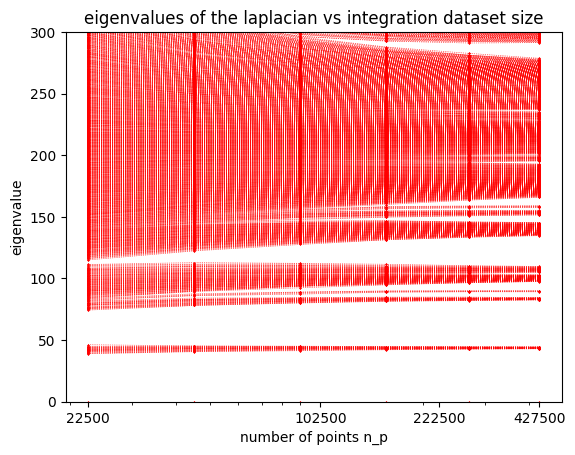

In [414]:
import matplotlib.pyplot as plt
#sort_eigvals_rounded=np.sort(eigvals_rounded)[0:200]
#plt.scatter(range(len(sort_eigvals_rounded)),sort_eigvals_rounded)
numbers_for_plotting=tf.repeat(tf.expand_dims(numbers_to_take,axis=-1),tf.shape(eigvals_all)[-1],axis=-1)
#join each eigval as hte number of points increase with a dotted line
#change the plot to a line plot
#change all the line colours to red and thin, with a small red x at each point
#fade the lines from blue to red corresponding to their index in the first axis of the array

plt.plot(numbers_for_plotting,eigvals_all,marker='x',linestyle='dotted',color='red',linewidth=0.5,markersize=1)


#change the x axis to log scale, labelled at the endpoints with one point in the middle
plt.xscale('log')
middle_pt=((numbers_to_take[-1]-numbers_to_take[0])//(5000*2))*5000 + numbers_to_take[0]
middle_pt2=((numbers_to_take[-1]-numbers_to_take[0])//(5000*5))*5000 + numbers_to_take[0]
ticks = tf.cast(np.concatenate((numbers_to_take[[0,-1]],np.array([middle_pt,middle_pt2])),axis=0),tf.int32).numpy()
plt.xticks(ticks,ticks)
#label the x axis as number of points n_p
#label the y axis as eigenvalue
plt.xlabel('number of points n_p')
plt.ylabel('eigenvalue')
#title the plot as eigenvalues of the laplacian as number of points increases
plt.title('eigenvalues of the laplacian vs integration dataset size')
plt.ylim(0,300)


In [504]:

def curly_brace(x, y, width, height, ax):
    q = height / 4
    # ax.plot([x, x, x + width/2, x + width, x + width],
    #         [y - height/2, y + height/2, y + q, y + height/2, y - height/2],
    #         color='black')
    ax.plot([x, x+width, x + width/2, x + width, x],
            [y - height/2, y -q, y, y +q , y + height/2],
            color='black',linewidth=0.5)

def cluster_vector(vector, min_clusters=2, max_clusters=10, ax=None,seed=42):
    X = np.array(vector).reshape(-1, 1)

    silhouette_scores = []
    for n_clusters in range(max(2, min_clusters), min(max_clusters + 1, len(X))):
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
        cluster_labels = kmeans.fit_predict(X)
        silhouette_scores.append(silhouette_score(X, cluster_labels))

    optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + max(2, min_clusters)

    kmeans = KMeans(n_clusters=optimal_clusters, random_state=seed)
    cluster_labels = kmeans.fit_predict(X)

    groups = []
    for i in range(optimal_clusters):
        group_values = X[cluster_labels == i]
        mean_value = np.mean(group_values)
        rangevals= np.max(group_values)-np.min(group_values)
        count = len(group_values)
        groups.append({
            'group_id': i,
            'mean_value': mean_value,
            'count': count,
            'rangevals':rangevals,
            'indices':cluster_labels
        })

    groups.sort(key=lambda x: x['mean_value'])

    if ax is not None:
        x_position = 427500
        for group in groups:
            y_position = group['mean_value']
            count = group['count']
            rangevals=group['rangevals']

            # Add curly brace
            curly_brace(x_position, y_position, 20000, rangevals, ax)

            # Add label
            ax.text(x_position + 25000, y_position, str(count),
                    va='center', ha='left', fontsize=10)
    print("Clustered groups:")
    for group in groups:
        print(f"Group {group['group_id']}: Mean = {group['mean_value']:.2f}, Count = {group['count']}")

    return groups

# Example usage (assuming you have an existing plot)
# fig, ax = plt.subplots(figsize=(12, 6))
# ... (your existing plot code here)

# vector = [1.2, 1.3, 1.1, 2.8, 3.0, 2.9, 5.5, 5.7, 5.6, 8.1, 8.3, 8.2]


# plt.show()  # Uncomment this if you want to show the plot

# print("Clustered groups:")
# for group in result:
#     print(f"Group {group['group_id']}: Mean = {group['mean_value']:.2f}, Count = {group['count']}")

Clustered groups:
Group 5: Mean = 0.00, Count = 1
Group 2: Mean = 43.61, Count = 20
Group 1: Mean = 83.41, Count = 20
Group 9: Mean = 89.58, Count = 4
Group 3: Mean = 100.10, Count = 60
Group 7: Mean = 107.21, Count = 30
Group 6: Mean = 137.45, Count = 50
Group 0: Mean = 142.42, Count = 50
Group 8: Mean = 153.34, Count = 20
Group 4: Mean = 158.20, Count = 5


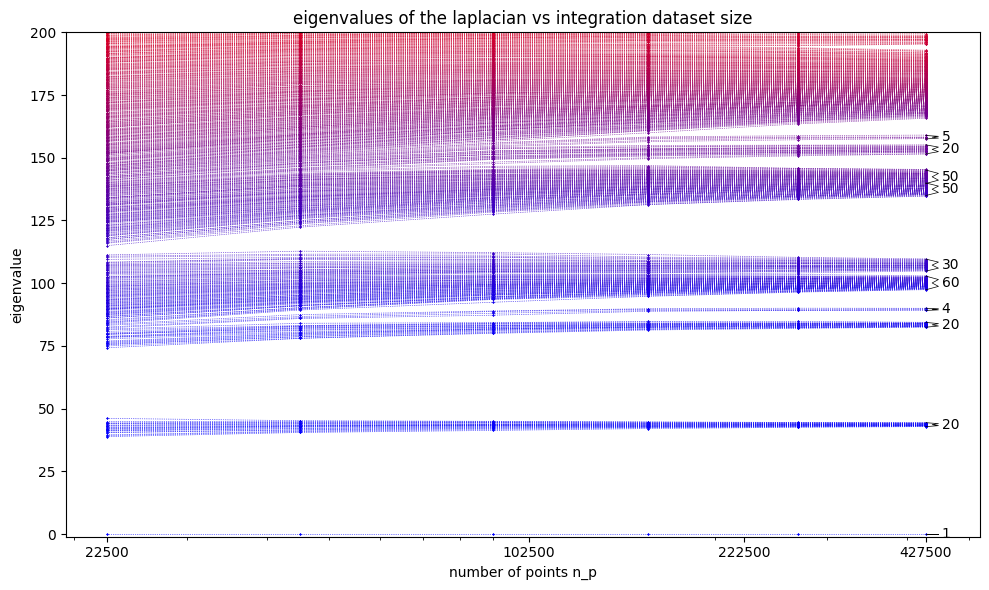

In [517]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

numbers_for_plotting=tf.repeat(tf.expand_dims(numbers_to_take,axis=-1),tf.shape(eigvals_all)[-1],axis=-1)
# Create a custom colormap from blue to red
colors = [(0, 0, 1), (1, 0, 0)]  # R -> G -> B
n_bins = eigvals_all.shape[1]//2  # Number of color bins (1225 eigenvalues)
cmap = LinearSegmentedColormap.from_list('red_to_blue', colors, N=n_bins)

# Plot setup
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each eigenvalue evolution with a different color
for i in range(n_bins):
    color = cmap(i / (n_bins - 1))
    ax.plot(numbers_for_plotting[:,i], eigvals_all[:,i],
            marker='x', linestyle='dotted', color=color, linewidth=0.5, markersize=1)

# Set x-axis to log scale
ax.set_xscale('log')

# Set x-axis ticks
middle_pt = ((numbers_to_take[-1]-numbers_to_take[0])//(5000*2))*5000 + numbers_to_take[0]
middle_pt2 = ((numbers_to_take[-1]-numbers_to_take[0])//(5000*5))*5000 + numbers_to_take[0]
ticks = np.concatenate((numbers_to_take[[0,-1]], np.array([middle_pt, middle_pt2])))
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

# Set labels and title
ax.set_xlabel('number of points n_p')
ax.set_ylabel('eigenvalue')
ax.set_title('eigenvalues of the laplacian vs integration dataset size')

# Set y-axis limit
ax.set_ylim(-1, 200)
#ax.set_xlim(420000, 430000)
eigvals_to_test=((eigvals_all[-1])[eigvals_all[-1]<165])
result_clustering = cluster_vector(eigvals_to_test, min_clusters=10, max_clusters=11, ax=ax,seed=41)

plt.tight_layout()
plt.show()

In [422]:
eig_shifts_without_alphaprime*0.01**3

array([[-0.1226657 -4.3541331e-09j, -0.06689466+3.2080507e-09j,
         0.09877396-7.6878148e-09j, ..., -0.06712726+1.0888892e-08j,
        -0.04258936-2.6959184e-09j, -0.09193552-2.3660593e-09j],
       [-0.16058573+1.5052115e-10j, -0.06130592-3.4227760e-10j,
         0.05164534+7.6246769e-09j, ..., -0.02244449+4.0129561e-10j,
        -0.11535198+2.5837883e-09j, -0.09829624+5.2293760e-09j],
       [-0.17636256+3.5356080e-09j, -0.12711039+1.6603066e-08j,
         0.06386614+1.5562938e-09j, ..., -0.08692715+2.7021794e-09j,
        -0.13897733-4.2564254e-09j, -0.10833836+2.3886311e-09j],
       [-0.15190963+5.9191065e-09j, -0.05330896-3.1782608e-09j,
         0.04517243+6.5890720e-09j, ..., -0.09597084+8.4933260e-09j,
        -0.03360775+3.8783168e-09j, -0.13956729-1.0997127e-08j],
       [-0.18714295+2.9413028e-08j, -0.04168477+1.2495666e-09j,
         0.08196873+6.3223909e-10j, ..., -0.08355992+8.1199392e-10j,
        -0.10163185+1.4375289e-09j, -0.1242699 +4.8506941e-09j],
       [-0

In [525]:
result_clustering

[{'group_id': 5,
  'mean_value': 1.2702463436653488e-06,
  'count': 1,
  'rangevals': 0.0,
  'indices': array([5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 9, 9,
         9, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 7,
         7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
         7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
         6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 8, 8, 8,
         8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 4, 4, 4, 4], dtype=int

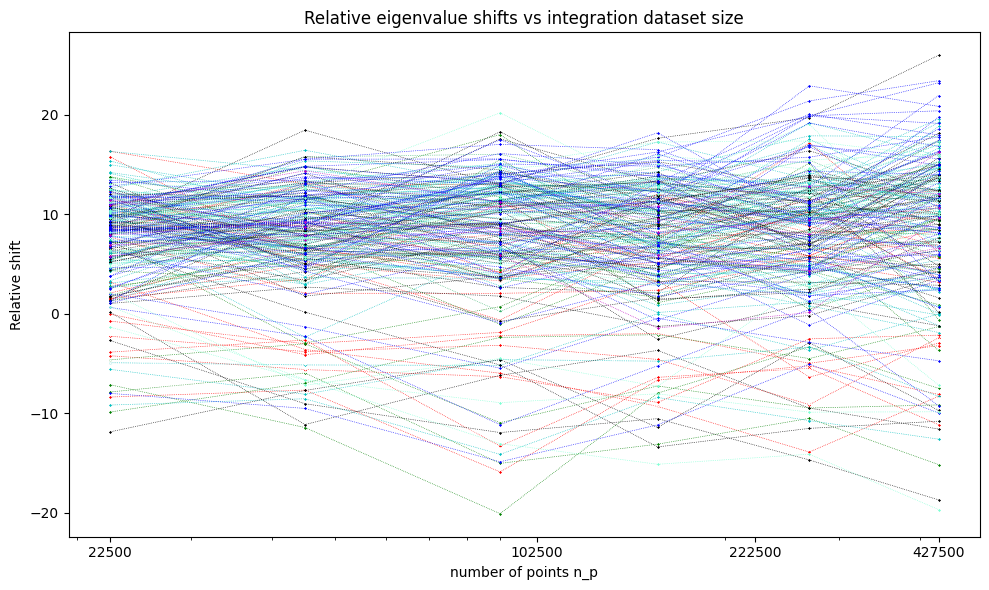

In [531]:
#You can create a separate plot showing the relative shifts (shift / original eigenvalue) to highlight which eigenvalues are most affected by the perturbation.
relative_shifts = eig_shifts_without_alphaprime[:,:260]*0.05**3 #/ eigvals_all[:,:260]

fig, ax = plt.subplots(figsize=(10, 6))
color_list=['b','g','r','c','m','y','k','w','aquamarine','mediumseagreen']

for i in range(1,260):#i.e omit the biggest
    #color according to the number from 1 to 10 (i.e. red, green, blue etc)
    color= color_list[result_clustering[0]['indices'][i]]
    #print(color_index)

    ax.plot(numbers_for_plotting[:,i], relative_shifts[:,i],
            marker='x', linestyle='dotted', color=color, linewidth=0.5, markersize=1)

ax.set_xscale('log')
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_xlabel('number of points n_p')
ax.set_ylabel('Relative shift')
ax.set_title('Relative eigenvalue shifts vs integration dataset size')

plt.tight_layout()
plt.show()

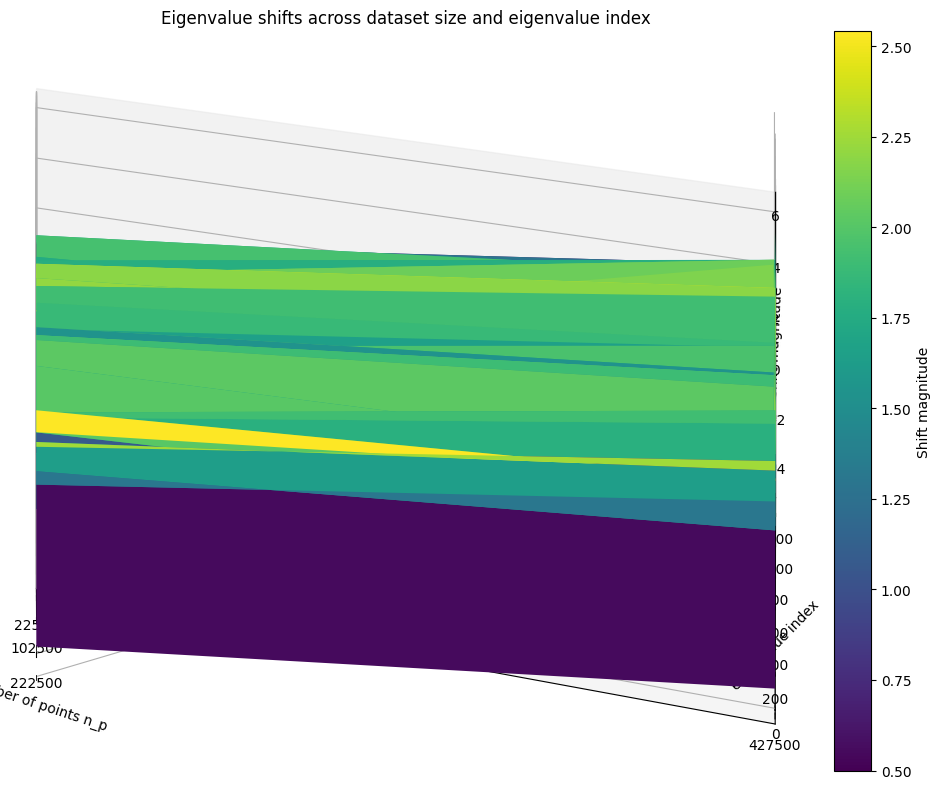

In [435]:
#create a 3D surface plot to show how the shifts vary across both eigenvalue index and dataset size.
from mpl_toolkits.mplot3d import Axes3D
n_bins= eigvals_all.shape[1]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(numbers_to_take, np.arange(n_bins))
Z = eig_shifts_without_alphaprime.T*0.03**3

surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

ax.set_xlabel('number of points n_p')
ax.set_ylabel('eigenvalue index')
ax.set_zlabel('Shift magnitude')
ax.set_title('Eigenvalue shifts across dataset size and eigenvalue index')

ax.set_xscale('log')
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)

plt.colorbar(surf, ax=ax, label='Shift magnitude')
plt.tight_layout()
plt.show()